In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
%matplotlib inline

def softmax(arr):
    return np.exp(arr) / np.sum(np.exp(arr))

## Corpus parameters
K = 2
xi = 1000 # Approximate number of words
T = 20
linspace_t = np.linspace(0, T-1, num=T)
V = 10

## Random Betas
# prior_dirichlet = np.repeat(1./V, V)
# beta = np.random.dirichlet(prior_dirichlet, K)

beta = np.array([[0, 0, 0, 0.3, 0.7, 0, 0, 0, 0, 0], [0, 0, 0.2, 0, 0, 0, 0, 0.3, 0.3, 0.2]])

alphas = np.zeros((T, K))
linspace_4pi = np.linspace(0, 4*np.pi, num=T)
alphas[:,0] = np.sin(linspace_4pi) 
alphas[:,1] = np.cos(linspace_4pi) 

### Generate a corpus

In [47]:
import string

## Initialise the vocabulary
vocab = []
for w in range(V):
    vocab.append(string.ascii_lowercase[w])

corpus = {}
for d in range(T):
    corpus[d] = {}
    N = np.random.poisson(xi)
    for w in range(N):
        theta = softmax(alphas[d])
#         topic_distrib = np.random.multinomial(1, theta)
        topic_distrib = np.random.multinomial(1, alphas[d])
        z = np.where(topic_distrib == 1)[0][0]
        word_distrib = np.random.multinomial(1, beta[z])
        w = np.where(word_distrib == 1)[0][0]
        w_key = vocab[w]
        if w_key not in corpus[d]:
            corpus[d][w_key] = 0
        corpus[d][w_key] += 1

from preprocessing import preprocess_corpus
count_max = 200.
normalise = False
corpus = preprocess_corpus(corpus, vocab, threshold=count_max, normalise=normalise)
# corpus.dump('corpus_test.pkl')

### Import the corpus

In [2]:
corpus = pd.read_pickle('corpus_test.pkl')

### Visualise the betas

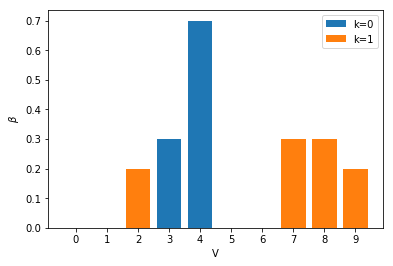

In [3]:
linspace_V = np.linspace(0, V-1, num=V)

plt.figure(1)
plt.bar(linspace_V, beta[0], label='k=0')
plt.bar(linspace_V, beta[1], label='k=1')
plt.xticks(np.arange(0, 10, 1.0))
plt.legend(loc=1)
plt.xlabel('V')
plt.ylabel(r'$\beta$')
plt.savefig('betas.png')

### Visualise the thetas

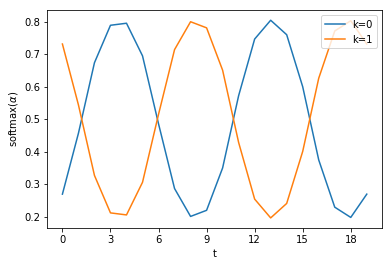

In [4]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

alphas_softmax = np.zeros(shape=alphas.shape)
for t, alpha_t in enumerate(alphas):
    alphas_softmax[t] = softmax(alpha_t)
alphas_softmax = alphas_softmax.T
labels = ['k=0', 'k=1']
for y_arr, label in zip(alphas_softmax, labels):
    plt.plot(linspace_t, y_arr, label=label)

plt.xlabel('t')
plt.ylabel(r'softmax($\alpha$)')
plt.legend(loc=1)
plt.savefig('mu.png')

### Fit

In [3]:
from dtm_alpha import DTM_Alpha

n_it = 500
var_init = 1
var_basic = 0.001
var_prop = 1
autoreg = False
dtm_alpha = DTM_Alpha(K=K, sigma_0_sq=var_init, sigma_sq=var_basic, 
        delta_sq=var_prop, autoreg=autoreg)
dtm_alpha.beta = beta
dtm_alpha.fit(corpus=corpus, n_it=n_it)

dtm_alpha.py:147: RuntimeWarning: overflow encountered in exp
  r = np.exp(p_alpha_prop - p_alpha)


Iteration: 10
Total alpha changes: 208
Alpha update rate: 0.5200
Iteration: 20
Total alpha changes: 432
Alpha update rate: 0.5400
Iteration: 30
Total alpha changes: 650
Alpha update rate: 0.5417
Iteration: 40
Total alpha changes: 864
Alpha update rate: 0.5400
Iteration: 50
Total alpha changes: 1083
Alpha update rate: 0.5415
Iteration: 60
Total alpha changes: 1288
Alpha update rate: 0.5367
Iteration: 70
Total alpha changes: 1498
Alpha update rate: 0.5350
Iteration: 80
Total alpha changes: 1706
Alpha update rate: 0.5331
Iteration: 90
Total alpha changes: 1918
Alpha update rate: 0.5328
Iteration: 100
Total alpha changes: 2112
Alpha update rate: 0.5280
Iteration: 110
Total alpha changes: 2322
Alpha update rate: 0.5277
Iteration: 120
Total alpha changes: 2543
Alpha update rate: 0.5298
Iteration: 130
Total alpha changes: 2762
Alpha update rate: 0.5312
Iteration: 140
Total alpha changes: 2977
Alpha update rate: 0.5316
Iteration: 150
Total alpha changes: 3171
Alpha update rate: 0.5285
Iteratio

### Print and dump

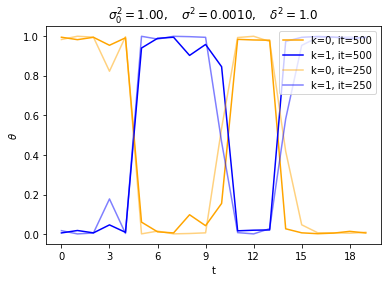

In [4]:
# Calculate the softmax
history_alpha = dtm_alpha.hist_alpha
labels = []
curves = []
settings = []
colours = ['orange', 'b']
for it in xrange(0, 2):
    idx = n_it - int(it * n_it/2)
    alphas_last_proposed = history_alpha[idx-1]
    alphas_softmax_last_proposed = np.zeros(shape=alphas_last_proposed.shape)
    for t, alphas_last_proposed_t in enumerate(alphas_last_proposed):
        alphas_softmax_last_proposed[t] = softmax(alphas_last_proposed_t)
    alphas_softmax_last_proposed = alphas_softmax_last_proposed.T
    for id_label, alpha in enumerate(alphas_softmax_last_proposed):
        curves.append(alpha)
        settings.append((colours[id_label],1-(it*0.5)))
        labels.append('k=%d, it=%d' % (id_label, idx))

# Plot the figure
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

for y_arr, label, setting in zip(curves, labels, settings):
    plt.plot(linspace_t, y_arr, label=label, color=setting[0], alpha=setting[1])
title_fig = r'$\sigma_0^2=%.2f,\quad \sigma^2=%.4f,\quad \delta^2=%.1f$' \
        % (var_init, var_basic, var_prop)
plt.title(title_fig)
plt.legend(loc=1)
plt.xlabel('t')
plt.ylabel(r'$\theta$')

# Save the plot and the model
name_model_out = 'init_%.0E|basic_%.0E|prop_%.0E|it_%d|autoreg_%s' \
        % (var_init, var_basic, var_prop, n_it, str(autoreg))
plt.savefig('results/' + name_model_out + '.png', dpi=300)
vars_dtm = vars(dtm_alpha)
with open('models/' + name_model_out + '.pkl', 'wb') as f:
        pkl.dump(vars_dtm, f)

### Load, fit, and dump

Iteration: 500
Total alpha changes: 2796
Alpha update rate: 0.1398
Iteration: 510
Total alpha changes: 2841
Alpha update rate: 0.1393
Iteration: 520
Total alpha changes: 2903
Alpha update rate: 0.1396
Iteration: 530
Total alpha changes: 2957
Alpha update rate: 0.1395
Iteration: 540
Total alpha changes: 3022
Alpha update rate: 0.1399
Iteration: 550
Total alpha changes: 3087
Alpha update rate: 0.1403
Iteration: 560
Total alpha changes: 3138
Alpha update rate: 0.1401
Iteration: 570
Total alpha changes: 3186
Alpha update rate: 0.1397
Iteration: 580
Total alpha changes: 3242
Alpha update rate: 0.1397
Iteration: 590
Total alpha changes: 3297
Alpha update rate: 0.1397
Iteration: 600
Total alpha changes: 3362
Alpha update rate: 0.1401
Iteration: 610
Total alpha changes: 3416
Alpha update rate: 0.1400
Iteration: 620
Total alpha changes: 3465
Alpha update rate: 0.1397
Iteration: 630
Total alpha changes: 3523
Alpha update rate: 0.1398
Iteration: 640
Total alpha changes: 3578
Alpha update rate: 0.

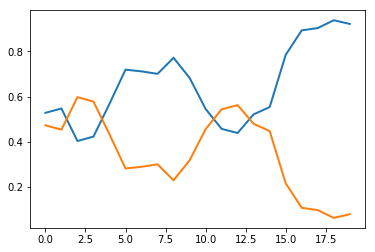

In [5]:
# from dtm_alpha import DTM_Alpha

n_it = 500
n_it_add = 500
var_init = 1
var_basic = 0.001
var_prop = 1
autoreg=True
name_model_in = 'init_%.0E|basic_%.0E|prop_%.0E|it_%d|autoreg_%s' \
        % (var_init, var_basic, var_prop, n_it, str(autoreg))
name_model_out = 'init_%.0E|basic_%.0E|prop_%.0E|it_%d|autoreg_%s' \
        % (var_init, var_basic, var_prop, n_it + n_it_add, str(autoreg))

dtm_alpha = DTM_Alpha()
dtm_alpha.load_fit('models/' + name_model_in + '.pkl', n_it=n_it_add)

history_alpha = dtm_alpha.hist_alpha
alphas_last_proposed = history_alpha[n_it-1]
alphas_softmax_last_proposed = np.zeros(shape=alphas_last_proposed.shape)
for t, alphas_last_proposed_t in enumerate(alphas_last_proposed):
    alphas_softmax_last_proposed[t] = softmax(alphas_last_proposed_t)

plt.plot(linspace_t, alphas_softmax_last_proposed, linewidth=2)

## Save the results
# plt.savefig('results/' + name_model_out + '.png')
# vars_dtm = vars(dtm_alpha)
# with open('models/' + name_model_out + '.pkl', 'wb') as f:
#         pkl.dump(vars_dtm, f)

### Plotting the alphas in 3D

In [8]:
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.graph_objs as go

alphas_softmax_proposed = np.zeros(shape=history_alpha.shape)

diff_min = 10000
idx_min = -1
for it, alpha_it in enumerate(history_alpha):
    for t, alpha_proposed_t in enumerate(alpha_it):
        alphas_softmax_proposed[it][t] = softmax(alpha_proposed_t)
    diff_abs = np.abs(alphas_softmax - alphas_softmax_proposed[it]).sum()
    if diff_abs < diff_min:
        diff_min = diff_abs
        idx_min = it
    
n_alphas = alphas_softmax_proposed.shape[2]
list_alphas = []
for i in range(n_alphas):
    alpha = dict(z = alphas_softmax_proposed[:, :, i], type='surface')
    list_alphas.append(alpha)
fig = go.Figure(data=list_alphas)

py.iplot(fig)